PCA, Nearest-Neighbors Classification and Clustering
====================================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This tour details [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (dimentionality reduction), supervised classification using nearest neighbors
and unsupervised [clustering](https://en.wikipedia.org/wiki/Unsupervised_learning) using [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering).


We recommend that after doing this Numerical Tours, you apply it to your
own data, for instance using a dataset from [LibSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/).


_Disclaimer:_ these machine learning tours are intended to be
overly-simplistic implementations and applications of baseline machine learning methods.
For more advanced uses and implementations, we recommend
to use a state-of-the-art library, the most well known being
[Scikit-Learn](http://scikit-learn.org/).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

Usefull function to convert to a column vector.

In [34]:
def MakeCol(y): return y.reshape(-1,1)
def MakeRow(y): return y.reshape(1,-1)
def find(x): return np.nonzero(x)[0]

Dataset Loading
---------------
We use here the famous
[IRIS dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) of Fisher.
The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor).
 Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres.


Helpers.

Load the dataset.

In [3]:
from scipy import io
name = 'iris'
U = io.loadmat('nt_toolbox/data/ml-' + name)
A = U['A']

Randomly permute it.

In [4]:
A = A[np.random.permutation(A.shape[0]),:]

Separate the features $ (x_i)_{i=1}^n $from the class information.
The feature are stored as the row of a matrix $X \in \RR^{n \times p}$
Be sure to start the class at index 1.

In [5]:
X = A[:,0:-1]
y = MakeCol( A[:,-1] )
y = y-y.min()+1

$n$ is the number of samples, $p$ is the dimensionality of the features,
$k$ is the number of classes.

In [6]:
[n,p] = X.shape
k = int( y.max() )
print(n,p,k)

150 4 3


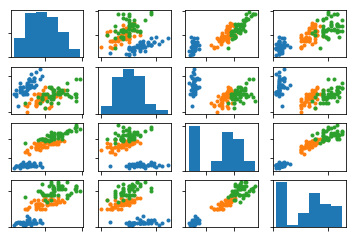

In [7]:
pmax = min(p,8)
kdisp = 0
plt.clf
for i in np.arange(0,pmax):
    for j in np.arange(0,pmax):
        kdisp = kdisp + 1
        plt.subplot(pmax,pmax,kdisp)
        if i==j:
            plt.hist(X[:,i],6)
            plt.axis('tight')
        else:
            for m in np.arange(1,k+1):
                I = np.nonzero(y==m)[0]
                plt.plot(X[I,j],X[I,i], '.')
        plt.axis('tight')
        plt.tick_params(axis='x', labelbottom='off')
        plt.tick_params(axis='y', labelleft='off')

Dimenionality Reduction and PCA
-------------------------------
In order to display in 2-D or 3-D the data, [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction)
is needed.
The simplest method is the [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA),
which perform an
orthogonal linear projection on the principal axsis (eigenvector) of the
covariance matrix.


Compute [empirical mean](https://en.wikipedia.org/wiki/Sample_mean_and_covariance)
$$    m = \frac{1}{n} \sum_{i=1}^n x_i \in \RR^p $$
and [covariance](https://en.wikipedia.org/wiki/Sample_mean_and_covariance)
$$ C = \frac{1}{n} \sum_{i=1}^n (x_i-m) (x_i-m)^\top \in \RR^{p \times p}. $$
Denoting $\tilde X = X - 1_p m^\top $, one has $C=\tilde X^\top
\tilde X$.

In [8]:
def Xm(X): return X-X.mean(axis=0)
def Cov(X): return Xm(X).transpose().dot( Xm(X) )

Display the covariance matrix.

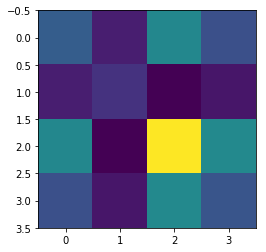

In [9]:
plt.clf
plt.imshow(Cov(X));

Compute PCA ortho-basis using the
[SVD decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)
$$ \tilde X = U \text{diag}(d) V  $$
where $U \in \RR^{n \times p}$ and $V \in \RR^{p \times p}$ have
orthonormal columns. $V$ are the principal directions of variance
 and
are order by decreasing variances.

In [10]:
U, D, V = np.linalg.svd(X)

Compute the feature in the PCA basis, $z_i=V^\top (x_i-m) $, stored in matrix
format as $Z=\tilde X V$.

In [11]:
Z = Xm(X).dot( V.transpose())

Plot the singular values of the covariances, which corresponds to the standard deviation of the data
along the principal directions.

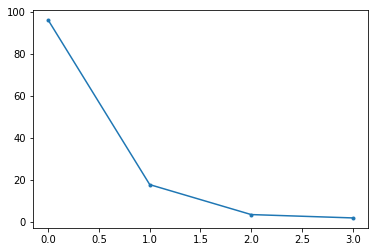

In [12]:
plt.clf
plt.plot(D, '.-')
plt.axis('tight');

The first dimensions of the $z_i$ are the optimal way to linearly
embed the data in a low dimensional space.
This can be used for display in 2-D using the first two dimension.

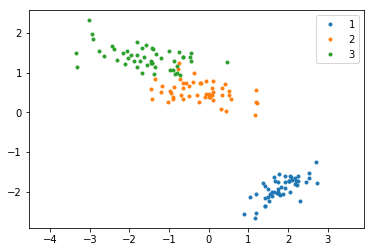

In [13]:
plt.clf
for i in np.arange(1,k+1):
    I = np.nonzero(y==i)[0]
    plt.plot(Z[I,0], Z[I,1], '.', label=str(i))
plt.axis('tight') 
plt.axis('equal')
plt.legend();

Similar display in 3-D.

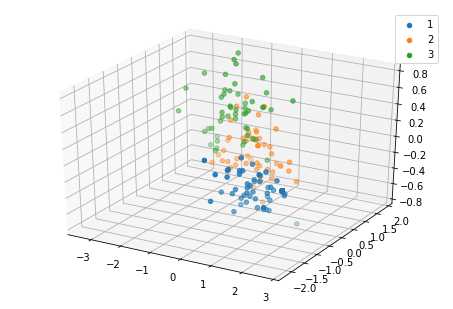

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
plt.clf
for i in np.arange(1,k+1):
    I = np.where(y==i)
    ax.scatter(Z[I,0], Z[I,1], Z[I,2], '.', label=str(i))
plt.axis('tight') 
plt.axis('equal')
plt.legend();

Supervised Learning: Nearest Neighbor Classification
----------------------------------------------------
Probably the simplest method for supervised classification is [Nearest
Neighbor](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) ($R$-NN), where $R$ is a parameter indexing the number of neighbor.
Increasing $R$ is important to cope with noise and obtain smoother
decision boundary, and hence better generalization performance.


The class predicted for a point $x$ is the one which is the most
represented among the $R$ points $(x_i)_i$ which are the closed to
$x$.



Split into training and testing.

In [15]:
n0 = round(.5*n)
n1 = n-n0
X0 = X[0:n0,:]  
y0 = y[0:n0]
X1 = X[n0:,:] 
y1 = y[n0:]

Macro to compute pairwise squared Euclidean distance matrix.

In [16]:
from sklearn.metrics.pairwise import pairwise_distances
def DistPoint(X,x): return pairwise_distances(X,MakeRow(x))

Compute Euclidean distance between some $x$
and all other $x_{1,j}$ in the training set.

In [17]:
i = 0 
x = X1[i,:]  # could be any point
D = DistPoint(X0,x)

Sort the distance and generate the list of sorted classes $ y_\sigma = (y_{\si(i)})_i$. This
generate an indexing $\si$ (a permutation of $\{1,\ldots,n\}$) such that
$$ \norm{x-x_{\si(1)}} \leq \norm{x-x_{\si(2)}} \leq \ldots \leq \norm{x-x_{\si(n)}}. $$

In [18]:
I = np.argsort(D.flatten())
ys = y[I]

Function to compute the histogram of classes.

In [19]:
def myhist(u): 
    q = u.shape[1]
    h = np.zeros((k,q))
    for i in np.arange(0,k):
        for j in np.arange(0,q):
            h[i,j] = sum(u[:,j]==i+1)
    return h

For a given $R$, one can compute the histogram of class apparition
$$ h_\ell \eqdef \frac{1}{R} \enscond{ i }{ \si(i) \in \{1,\ldots,R\} }
  = \sharp \si^{-1}( \{1,\ldots,R\} ). $$
The decision class for $x$ is then the maximum of the histogram
$$ c(x) \eqdef \text{argmax}_{\ell} h_\ell $$

In [20]:
R = 5
h = myhist(ys[0:R,:]) / R
c = np.argmax(h)+1
print( 'c(x)=' + str(c) + ', true class=' + str(int(y1[i])) )

c(x)=3, true class=3


Display the histigram $(h_\ell)_\ell$ of reparttion of class indexes as $R$ grows.

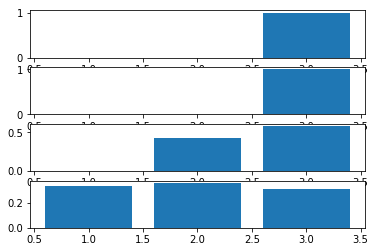

In [21]:
Rlist = ( np.array([.05, .1, .5, 1])*n0 ).round()
plt.clf
for i in np.arange(0,Rlist.size):
    R = int( Rlist[i] )
    h = myhist(ys[0:R,:]) / R
    plt.subplot(Rlist.size,1,i+1)
    plt.bar(np.arange(1,k+1), h)

__Exercise 1__

Perform the NN classification for all the points in the test set, and for varying $R$.
Show how the classification score $S$ (number of correctly classified points)
evolves with $R$
lot(1:Rmax, S, '.-', 'MarkerSize', ms);

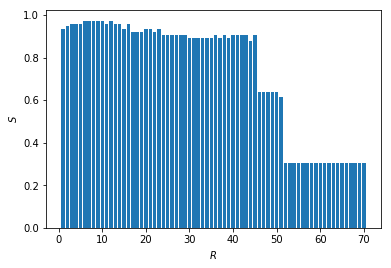

In [22]:
run -i nt_solutions/ml_1_pca_nn/exo1

In [23]:
## Insert your code here.

__Exercise 2__

Display, as a function of the position in 2-D PCA space, the class output by
the $R$-NN method when applied in 2-D.

In [24]:
## Insert your code here.

Unsupervised Learning: $k$-means
----------------------------------
In an [un-supervised setting](https://en.wikipedia.org/wiki/Unsupervised_learning), the class information $y$ is not
available. The basic problem is then to recover class information from
the knowledge of $x$ only. This corresponds to the [clustering problem](https://en.wikipedia.org/wiki/Cluster_analysis).

The most basic algorithm is the <https://en.wikipedia.org/wiki/K-means_clustering $k$-means>, which tries to recover the
class index $\bar y_i=\ell$ from the distance $ \norm{x_i-c_\ell} $
between the feature point $x_i$ and the class centroid $c_\ell$
(which are the unknown of the problem).


It does so by minimizing the following non-convex energy
  $$ \umin{ (c_\ell)_\ell } \sum_i \umin{\ell} \norm{x_i-c_\ell}^2   $$


We first initialize the class centroids $ (c_\ell)_\ell $ at random among the points.
They are stored in as the row of a matrix $ C \in \RR^{k \times p} $.

In [25]:
I = np.random.permutation(n)
I = I[0:k]
C = X[I,:]

The $k$-means algorithm iterate between first determining the class of
each point using the distance to the centroids
  $$ \forall i \in \{1,\ldots,n\}, \quad \bar y_i \leftarrow
          \uargmin{\ell} \norm{x_i-c_\ell}. $$

In [26]:
D = pairwise_distances(X,C)
yb = np.argmin(D, axis=1)

Display the centroids and the classes using colors.
This correspodns to a Voronoi diagram segmentation in the high
dimensional space, but here the display is done in 2D.

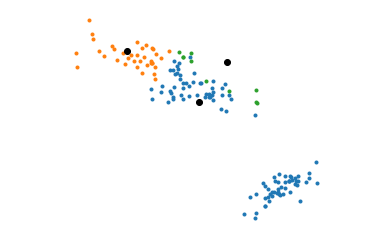

In [27]:
plt.clf
for i in np.arange(0,k):
    I = np.nonzero(yb==i)[0]
    plt.plot(Z[I,0], Z[I,1], '.')
CV = (C-np.mean(X,axis=0)).dot( V.transpose() )
for i in np.arange(0,k):
    plt.plot(CV[i,0], CV[i,1], 'ok')
plt.axis('tight')
plt.axis('equal')
plt.axis('off');

The second step of the $k$-means algorithm is to update the centroids
position to be the mean of the points inside each class
 $$ \forall \ell \in \{1,\ldots,k\}, \quad c_\ell \leftarrow
      \frac{ \sum_{i:y_i=\ell} x_i }{ \sharp \{i:y_i=\ell\} }. $$

In [28]:
for l in np.arange(0,k):
    C[l,:] = np.mean( X[yb==l,:], axis=0 )

__Exercise 3__

Peform several step of the $k$-means algorithm.
nit

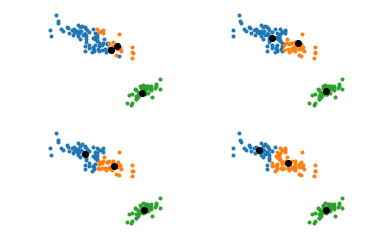

In [29]:
run -i nt_solutions/ml_1_pca_nn/exo3

In [30]:
## Insert your code here.

Display the histogram of (true, i.e. according to $y$) class  inside
each estimated class (i.e. according to $\bar y$).

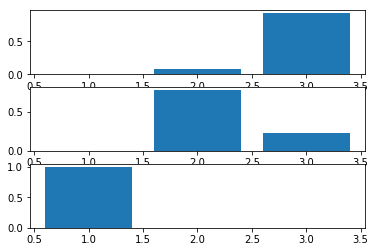

In [31]:
plt.clf
for l in np.arange(1,k+1):
    I = np.nonzero(yb==l-1)[0]
    h = myhist(y[I])
    h = h/h.sum()
    plt.subplot(k,1,l)
    plt.bar(np.arange(1,k+1),h)

__Exercise 4__

Implement better initialization strategies such as farthest point sampling or
[$k$-means++](https://en.wikipedia.org/wiki/K-means%2B%2B).

In [32]:
run -i nt_solutions/ml_1_pca_nn/exo4

In [33]:
## Insert your code here.